# Practical Implementation of a Deep Learning Object Detection Model 

This project is about detecting species of birds using Convolutional Neural Networks architectures. The dataset I am using has 2400 total images with 800 images per class of 3 classes of birds species. These classes are TurdusMerula, ErithacusRubecula and PeriparusAter. These images are tagged using an annotation tool. The TFRecords were created using the images and XML files and then fed into the model for training. I will be using Faster R-CNN and SSD ResNet50 for training. Faster R-CNN is a powerful state of the art model with good performnce and accuracy. But because of its power its slow in detecting from videos and in real time. I will also be traing an SSD ResNet50 which is a faster model but the accuracy is less. 

For both the models I will check the evaluation metrics and choose the better model for deployment and inferencing.

# Data Pre-processing

In [11]:
# importing all necassary packages for preprocessing data
import os
import seaborn as sns
import numpy as np
from matplotlib.pyplot import imread
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import shutil
%matplotlib inline

## Resolution distribution of images

Let's see the resolution distribution of the image dataset in order to select the right model for training.

In [2]:
dim1 = []
dim2 = []
for image_filename in os.listdir('./images'):
    name, ext = os.path.splitext(image_filename)
    try:
        if not ext == '.xml':
            img = imread('./images/'+image_filename)
            d1,d2,color = img.shape
            dim1.append(d1)
            dim2.append(d2)
    except:
        print(image_filename)
        continue

test
train


/home/msc1/anaconda3/envs/Env-7144COMP/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


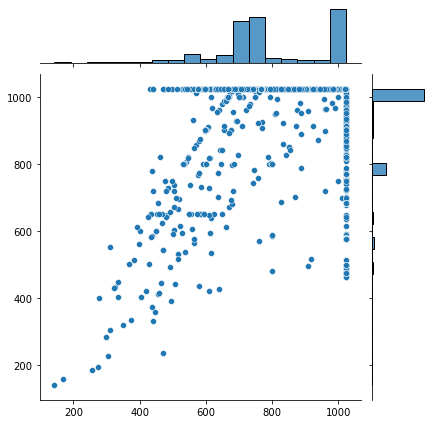

In [3]:
sns.jointplot(dim1,dim2)

As you can see the resolution of imost images lie in the range of 1000 through x and y axis. It would be better to choose the model that has been pre-trained on 1024 x 1024 images. Tensorflow Object Detection API has models trained on many different resolutions.

Below we have the minimum, maximum and mean of the resolutions

In [4]:
np.mean(dim1)

802.2516666666667

In [5]:
print('Min:', np.min(dim1))
print('Max:', np.max(dim1))

Min: 142
Max: 1024


In [6]:
np.mean(dim2)

923.885

In [7]:
print('Min:', np.min(dim2))
print('Max:', np.max(dim2))

Min: 140
Max: 1024


## Removing NoGood images and XML files

While tagging data there were lot images that didn't have the object in it or were not so clear. It was good idea to to tag those images as NoGood. But it is important to delete those files before creating TFRecords.

The below function extracts values from the XML file and creates a dataframe.

In [16]:
# function to extract values from xml files and creating a dataframe with those values
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
#         print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     float(root.find('size')[0].text),
                     float(root.find('size')[1].text),
                     member[0].text,
                     float(member[4][0].text),
                     float(member[4][2].text),
                     float(member[4][1].text),
                     float(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Converting the XML files to dataframe and analysing it to find filenames of NoGood values. This step is performed in order to delete images and xml files of NoGood values

In [17]:
image_path = os.path.join(os.getcwd(), 'images/')
print(image_path)
xml_df = xml_to_csv(image_path)
xml_df.head()

/home/msc1/Desktop/Tensorflow-Object-Detection-API/Base/v1/object_detection/images/


,filename,width,height,class,xmin,ymin,xmax,ymax
0,TurdusMerula407.jpg,577.0,1024.0,TurdusMerula,303.446203,366.505886,421.905274,467.196096
1,ErithacusRubecula491.jpg,1024.0,768.0,ErithacusRubecula,353.634672,273.307904,670.365328,573.435743
2,PeriparusAter167.jpg,634.0,1024.0,PeriparusAter,238.668763,461.473159,407.251208,750.958167
3,ErithacusRubecula744.jpg,1024.0,789.0,ErithacusRubecula,401.786832,313.582705,487.070831,394.930520
4,ErithacusRubecula393.jpg,1024.0,770.0,ErithacusRubecula,368.587850,166.460531,811.628956,582.611859


Check the unique values of column class

In [24]:
xml_df['class'].unique()

array(['TurdusMerula', 'ErithacusRubecula', 'PeriparusAter', 'NoGood'],
      dtype=object)

Below code shows all rows with NoGood values

In [23]:
xml_df.loc[xml_df['class'] == 'NoGood']

,filename,width,height,class,xmin,ymin,xmax,ymax
89,TurdusMerula20.jpg,576.0,1024.0,NoGood,222.440160,432.471444,354.127458,523.290270
111,ErithacusRubecula330.jpg,768.0,1024.0,NoGood,485.319753,259.631866,638.576521,366.343987
143,TurdusMerula310.jpg,576.0,1024.0,NoGood,113.806204,292.165014,197.638631,385.166613
167,TurdusMerula221.jpg,575.0,1024.0,NoGood,135.946084,127.713974,331.774178,280.970743
177,TurdusMerula465.jpg,768.0,1024.0,NoGood,301.859483,351.039494,553.879105,481.817245
...,...,...,...,...,...,...,...,...
2338,TurdusMerula197.jpg,768.0,1024.0,NoGood,542.081519,633.408096,699.879229,775.312512
2355,ErithacusRubecula169.jpg,1000.0,794.0,NoGood,576.581822,68.659565,818.210674,308.968040
2390,PeriparusAter311.jpg,768.0,1024.0,NoGood,435.085590,590.889986,562.799563,716.901107
2400,TurdusMerula279.jpg,768.0,1024.0,NoGood,218.823260,492.124513,407.839942,589.187133


As you can see there are 97 rows with NoGood values and similar number of XML files. Lets extract the filenames and create a list of filenames.

Creating a list of filenames that contains NoGood values

In [29]:
# dataframe containing only NoGood values
no_good_df = xml_df.loc[xml_df['class'] == 'NoGood']
# creating a list of filenames
no_good_list = list(no_good_df['filename'])
no_good_list

['TurdusMerula20.jpg',
 'ErithacusRubecula330.jpg',
 'TurdusMerula310.jpg',
 'TurdusMerula221.jpg',
 'TurdusMerula465.jpg',
 'TurdusMerula369.jpg',
 'TurdusMerula440.jpg',
 'PeriparusAter463.jpg',
 'TurdusMerula301.jpg',
 'TurdusMerula496.jpg',
 'TurdusMerula308.jpg',
 'TurdusMerula697.jpg',
 'TurdusMerula526.jpg',
 'TurdusMerula185.jpg',
 'TurdusMerula541.jpg',
 'TurdusMerula244.jpg',
 'TurdusMerula651.jpg',
 'PeriparusAter1.jpg',
 'TurdusMerula706.jpg',
 'TurdusMerula639.jpg',
 'TurdusMerula82.jpg',
 'TurdusMerula283.jpg',
 'TurdusMerula707.jpg',
 'PeriparusAter198.jpg',
 'TurdusMerula337.jpg',
 'TurdusMerula700.jpg',
 'TurdusMerula735.jpg',
 'TurdusMerula379.jpg',
 'TurdusMerula238.jpg',
 'TurdusMerula394.jpg',
 'TurdusMerula773.jpg',
 'TurdusMerula436.jpg',
 'TurdusMerula151.jpg',
 'PeriparusAter113.jpg',
 'TurdusMerula108.jpg',
 'TurdusMerula514.jpg',
 'TurdusMerula529.jpg',
 'TurdusMerula665.jpg',
 'PeriparusAter670.jpg',
 'ErithacusRubecula552.jpg',
 'TurdusMerula220.jpg',
 'Tur

## Script to delete NoGood images and XML files

In below script the images and xml files that are NoGood are deleted

In [39]:
# loop through the filename list
for file in no_good_list:
    # check if file exists
    if os.path.isfile(image_path + file):
#         print(image_path + file)
        # remove image and xml files
        os.remove(image_path + file)
        os.remove(image_path + file.replace('jpg', 'xml'))
    else:
        print(f"Error: {file} file not found")

Now let's create a new dataframe using xml_to_csv function from the image directory and check the lenght of the dataframe

In [40]:
xml_df_2 = xml_to_csv(image_path)
len(xml_df_2)

2323

The lenght of dataframe is reduced. Before it was 2420 and now it is 2323

Check the unique classes of the class column of the dataframe

In [41]:
xml_df_2['class'].unique()

array(['TurdusMerula', 'ErithacusRubecula', 'PeriparusAter'], dtype=object)

As you can see it does not contain NoGood as a class

Let's check any class with NoGood value again.

In [43]:
xml_df_2.loc[xml_df_2['class'] == 'NoGood']

,filename,width,height,class,xmin,ymin,xmax,ymax


It is empty because all the files with NoGood values have been deleted.